In [1]:
# import os
# from dotenv import load_dotenv

# load_dotenv()

# # 환경 변수로 자동 추적 (LangChain이 자동 감지)
# os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"  # 또는 "false"
# os.environ["LANGSMITH_PROJECT"] = "allforone"  # 프로젝트명

In [2]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]
sys.path.append(str(src_path))

print(sys.path[-1])
import os

print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src
/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


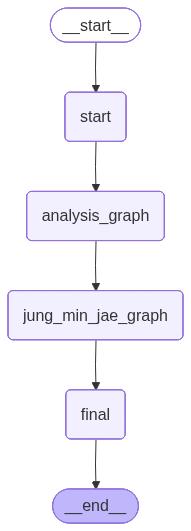

In [3]:
from agents.main.main_agent import graph_builder
graph = graph_builder.compile()
graph

In [4]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState


messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

thread = {"configurable": {"thread_id": "1"}}
result = await graph.ainvoke(
    {
        messages_key: [
            HumanMessage(
                content="서울 송파구 석촌동, 84타입, 120세대\n이메일은 dlwlstjq410@gmail.com"
            )
        ]
    },
    config=thread,
)

format_message(result[messages_key])

start_input target_area='서울 송파구 석촌동' main_type='84타입' total_units='120' email='dlwlstjq410@gmail.com' brand=None orientation=None parking_ratio=None terrain_condition=None gross_area=None floor_area_ratio_range=None building_coverage_ratio_range=None


/Users/seobi/PythonProjects/RAG_Commander/src/tools/rag/vector_store.py:33: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See <https://github.com/langchain-ai/langchain-postgres> for details about the new implementation.
  _pgvector_cache[collection_name] = PGVector(


서울 송파구
📎 주택담보대출_temp 링크: https://drive.google.com/uc?id=14bFqimqcLfoqZwghkIbNB5NR34csQ_9M&export=download
📎 매매수급지수_temp 링크: https://drive.google.com/uc?id=1nyF2XsE6YA1fNc0YFS0WL_2IPW4dHc_o&export=download
📎 국가적_정책_모음_temp 링크: https://drive.google.com/uc?id=1c8CM05eNU7wQQvq1INmgW5FPLPO7RjdG&export=download
[SGIS] 요청 URL: https://sgisapi.kostat.go.kr/OpenAPI3/stats/house.json?year=2020&adm_cd=11240&low_search=0&const_year=06&const_year=07&const_year=08&const_year=09&const_year=10&const_year=11&accessToken=5d1f30d2-6360-48a6-b185-1510d2098f12
[SGIS] 응답 코드: 200
📎 _연령층분포_temp 링크: https://drive.google.com/uc?id=1fpuLxuai1rtm5WBLYBPLrVQY01uORyzi&export=download
📎 주택청약FAQ_temp.csv 링크: https://drive.google.com/uc?id=1AK74t62rI6A5debc9uzATo8e3hFkwmpZ&export=download
📎 _인구이동_temp 링크: https://drive.google.com/uc?id=10ThrGATFRgU8oIlIYqyY2NG3cGA-pq5D&export=download
📎 _월별_매매가격_temp 링크: https://drive.google.com/uc?id=1gsgRcBuySbiIl9oMbUD32qD9AsO7rq8n&export=download
📎 _GDP_와_GRDP_temp 링크: https://dri

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 서울 송파구 석촌동, 84타입, 120세대                                                                             │
│ 이메일은 dlwlstjq410@gmail.com                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result.keys()

dict_keys(['messages', 'start_input', 'final_report', 'source', 'status', 'analysis_outputs'])

In [6]:
result['start_input']

{'target_area': '서울 송파구 석촌동',
 'main_type': '84타입',
 'total_units': '120',
 'email': 'dlwlstjq410@gmail.com',
 'brand': None,
 'orientation': None,
 'parking_ratio': None,
 'terrain_condition': None,
 'gross_area': None,
 'floor_area_ratio_range': None,
 'building_coverage_ratio_range': None}

In [7]:
# print(result['analysis_outputs']['location_insight'].keys())
# print(result['analysis_outputs']['location_insight']['result'])

In [8]:
# print(result['analysis_outputs'].keys())

In [9]:
# print(result['analysis_outputs']['policy_output'].keys())
# print(result['analysis_outputs']['housing_faq'].keys())
# print(result['analysis_outputs']['location_insight'].keys())
# print(result['analysis_outputs']['nearby_market'].keys())
# print(result['analysis_outputs']['population_insight'].keys())
# print(result['analysis_outputs']['supply_demand'].keys())
# print(result['analysis_outputs']['unsold_insight'].keys())

In [10]:
# 정책, 2개다 날짜, 클라우드 분석 가능 region_context은 최신뉴스, national_context 는 정책 뉴스 
# print(result['analysis_outputs']['policy_output']['region_context'])
# result['analysis_outputs']['policy_output']['national_context']

# 청약, housing_faq_context는 FAQ 로 나열 가능, housing_rule_context은 ..???
# result['analysis_outputs']['housing_faq']['housing_faq_context']
# result['analysis_outputs']['housing_faq']['housing_rule_context']

# 입지 분석  (거리 측정 및 호재)
# print(result['analysis_outputs']['location_insight']['kakao_api_distance_context'])
# print(result['analysis_outputs']['location_insight']['gemini_search'])

# 공급과 수요 - 10년이상 노후도, 전세 평균가, 매매가, 한국/미국 금리, 주택담보대출, 1인당gdp,grdp, 매매량, 분양 계획, 
# print(result['analysis_outputs']['supply_demand']['year10_after_house'])
# print(result['analysis_outputs']['supply_demand']['jeonse_price'])
# print(result['analysis_outputs']['supply_demand']['sale_price'])
# print(result['analysis_outputs']['supply_demand']['trade_balance'])
# print(result['analysis_outputs']['supply_demand']['use_kor_rate'])
# print(result['analysis_outputs']['supply_demand']['home_mortgage'])
# print(result['analysis_outputs']['supply_demand']['one_people_gdp'])
# print(result['analysis_outputs']['supply_demand']['one_people_grdp'])
# print(result['analysis_outputs']['supply_demand']['housing_sales_volume'])
# print(result['analysis_outputs']['supply_demand']['planning_move'])
# print(result['analysis_outputs']['supply_demand']['pre_pomise_competition'])

# 미분양 현황
# print(result['analysis_outputs']['unsold_insight']['unsold_unit'])

# 인구이동 - 연령층 분포, 인구 이동 
# print(result['analysis_outputs']['population_insight']['age_population_context'])
# print(result['analysis_outputs']['population_insight']['move_population_context'])

# 매매 비교
# print(result['analysis_outputs']['nearby_market']['result'])
# print(result['analysis_outputs']['nearby_market']['kakao_api_distance_context'])
# result['analysis_outputs']['nearby_market']['kakao_api_distance_context']



In [11]:

# %load_ext autoreload
# %autoreload 2
# from tools.context_to_csv import (
#     housing_faq_context_to_drive,
#     housing_rule_context_to_drive,
#     location_kakao_to_drive,
#     region_news_to_drive,
#     netional_news_to_drive,
#     jense_to_drive,
#     sales_to_drive,
#     rate_to_drive,
#     home_mortagage_to_drive,
#     housing_sales_volume_to_drive,
#     planning_move_to_csv,
#     pre_promise_competition_to_csv,
#     gdp_and_grdp_to_drive,
#     unsold_to_drive,
#     age_population_to_drive,
#     move_population_to_drive,
#     nearby_complexes_to_csv
# )
# address = result['start_input']['target_area']
# analysis_outputs = result['analysis_outputs']


# housing_faq_context_to_drive(analysis_outputs['housing_faq']['housing_faq_context'])
# housing_rule_context_to_drive(analysis_outputs['housing_faq']['housing_rule_context'])

# location_kakao_to_drive(analysis_outputs['location_insight']['kakao_api_distance_context'], address)

# region_news_to_drive(analysis_outputs['policy_output']['region_context'])
# netional_news_to_drive(analysis_outputs['policy_output']['national_context'])

# jense_to_drive(analysis_outputs['supply_demand']['jeonse_price'])
# sales_to_drive(analysis_outputs['supply_demand']['sale_price'])
# rate_to_drive(analysis_outputs['supply_demand']['use_kor_rate'])

# home_mortagage_to_drive(analysis_outputs['supply_demand']['home_mortgage'])
# housing_sales_volume_to_drive(analysis_outputs['supply_demand']['housing_sales_volume'],address)
# planning_move_to_csv(analysis_outputs['supply_demand']['planning_move'],address)
# # pre_promise_competition_to_csv(analysis_outputs['supply_demand']['pre_pomise_competition'],address)
# gdp_and_grdp_to_drive(analysis_outputs['supply_demand']['one_people_gdp'], analysis_outputs['supply_demand']['one_people_grdp'], address)

# unsold_to_drive(analysis_outputs['unsold_insight']['unsold_unit'],address)

# age_population_to_drive(analysis_outputs['population_insight']['age_population_context'],address)
# move_population_to_drive(analysis_outputs['population_insight']['move_population_context'],address)

# nearby_complexes_to_csv(analysis_outputs['nearby_market']['kakao_api_distance_context'],address)

In [12]:
result

{'messages': [HumanMessage(content='서울 송파구 석촌동, 84타입, 120세대\n이메일은 dlwlstjq410@gmail.com', additional_kwargs={}, response_metadata={}, id='62d866e2-25bf-45f9-baa4-31b21d38217e')],
 'start_input': {'target_area': '서울 송파구 석촌동',
  'main_type': '84타입',
  'total_units': '120',
  'email': 'dlwlstjq410@gmail.com',
  'brand': None,
  'orientation': None,
  'parking_ratio': None,
  'terrain_condition': None,
  'gross_area': None,
  'floor_area_ratio_range': None,
  'building_coverage_ratio_range': None},
 'final_report': '# 1. 사업환경 분석\n\n**[핵심 판단]**\n- 입지 종합 평가: ★★★★☆ (9·8호선 더블역세권 + 초품아, 생활편의 우수)\n- 정책 환경: 공급 확대·정비촉진 병행(2024~2025)으로 분양가 및 분양성에 미치는 영향이 상쇄되는 중립적 환경\n- 분양성 기여도: 입지(+) > 정책(±) → 순긍정\n- 주요 리스크: 2025~2032 대형 개발·정비 동시 진행에 따른 경쟁 심화(정책·사업 동시 추진, 출처: 정책시계열·주변호재)\n\n## 입지분석, 개발호재\n\n### 사업개요\n- 위치: 서울 송파구 석촌동(좌표 37.5035646, 127.103667) [출처 1]\n- 규모: 총 120세대, 주력 84타입 [출처 1]\n- 상품 포지션: 30~50대 자녀가구 실거주 중심 84㎡ 주력 수요 대응 [출처 1]\n\n### 입지분석\n- 한 줄 요약: 9·8호선 석촌 더블역세권(315~359m) + 초품아(석촌초 103m) + 생활편